## Importando dependências

In [1]:
# pip install tensorflow sklearn

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import shuffle

## Importando dataset e splitando em teste e treino

In [11]:
def split_time_windows_dataset(dataset, window_size = 20, step_size = 1, is_label = False):
    # split com janelas rolante
    splitted_dataset = list()
    split_size = len(dataset) - (window_size - step_size)
    offset = 0
    
    for _ in range(split_size):
        if is_label:
            splitted_dataset.append(dataset[offset:(window_size + offset)])
        else:
            splitted_dataset.append(dataset[offset:(window_size + offset), :])
        offset += step_size
        
    final_dataset = np.array(splitted_dataset)                            
    return final_dataset

def balance_dataset_labels(dataset):
    balanced_dataset = dataset.loc[dataset.iloc[:, -1].isin([251, 12, 3, 24, 7, 8, 6])]
    standart_label_dataset = dataset.loc[dataset.iloc[:, -1] == 0]
    slice_dataset = standart_label_dataset.iloc[0:2200]
    balanced_dataset = balanced_dataset.append(slice_dataset)
    balanced_dataset = shuffle(balanced_dataset)
    balanced_dataset.reset_index(inplace=True, drop=True)
    return balanced_dataset


HEADER = ["timestamp",'srcip', 'srcport', 'dstip', 'dstport', 'proto', 'total_fpackets', 'total_fvolume',
          'total_bpackets', 'total_bvolume', 'min_fpktl', 'mean_fpktl', 'max_fpktl', 'std_fpktl', 'min_bpktl',
          'mean_bpktl', 'max_bpktl', 'std_bpktl', 'min_fiat', 'mean_fiat', 'max_fiat', 'std_fiat', 'min_biat',
          'mean_biat', 'max_biat', 'std_biat', 'duration', 'min_active', 'mean_active', 'max_active', 'std_active',
          'min_idle', 'mean_idle', 'max_idle', 'std_idle', 'sflow_fpackets', 'sflow_fbytes', 'sflow_bpackets',
          'sflow_bbytes', 'fpsh_cnt', 'bpsh_cnt', 'furg_cnt', 'burg_cnt', 'total_fhlen', 'total_bhlen', "dscp", 'class']
initial_dataset = pd.read_csv('dataset-oi-2017-02-24.csv', names=HEADER)

# initial_dataset = balance_dataset_labels(initial_dataset)

# normalizando rótulos das classes
y = initial_dataset.iloc[:, -1].values
unique_labels = sorted(list(set(y)))
for i in range(len(y)):
    y[i] = unique_labels.index(y[i])

initial_dataset.iloc[:, -1] = y


## Criando modelo da rede neural

In [4]:
class Net:
    def build(self, shape = (41,), classes = 141):
        model = Sequential()
        model.add(Dense(200, input_shape=shape))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))            
        
        self.built = model
        
        return model
    
    def build_conv(self, shape = (None, 20, 41), classes = 141):
        model = Sequential()
        model.add(Conv1D(filters=32, kernel_size=3, input_shape=shape))
        model.add(MaxPooling1D(pool_size=2, strides=2))
        model.add(Conv1D(filters=32, kernel_size=3))
        model.add(MaxPooling1D(pool_size=2, strides=2))
        model.add(Flatten())
        model.add(Dense(64))
        model.add(Activation("relu"))
        model.add(Dense(32))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
            
        self.built = model
        
        return model
    
    def compile(self, learning_rate = 0.01, comms_round = 100):
        self.built.compile(loss = 'sparse_categorical_crossentropy', 
                      optimizer = SGD(learning_rate=learning_rate, decay=learning_rate / comms_round, momentum=0.9),
                      metrics = ['accuracy'])

## Criando modelo do servidor

In [5]:
class Server:
    def __init__(self, dataset = list(), model = Net(), learning_rate = 0.01, comms_round = 100, num_clients = 5):
        self.num_clients = num_clients
        self.dataset = dataset
        X = self.dataset.iloc[:, 5:-1].values
        y = self.dataset.iloc[:, -1].values
        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64)
        
        self.num_labels = len(set(y))
        
#         X = split_time_windows_dataset(X)
#         y = split_time_windows_dataset(y, is_label = True)
        
        self.input_shape = X.shape[1:]
        
        self.global_model = model
#         self.global_model.build_conv(classes = self.num_labels, shape = self.input_shape)
        self.global_model.build(classes = self.num_labels, shape = self.input_shape)
        
        self.learning_rate = learning_rate
        self.comms_round = comms_round
        self.global_model.compile(self.learning_rate, self.comms_round)
        
    def split_dataset(self, clients):
        num_clients = len(clients)
        split_size = len(self.dataset) // num_clients
        splitted_dataset = [self.dataset[i:i + split_size] for i in range(0, split_size * num_clients, split_size)]
        for i in range(0, num_clients):
            local_dataset = splitted_dataset[i]
            clients[i].local_dataset = local_dataset
            clients[i].num_labels = self.num_labels
            clients[i].input_shape = self.input_shape
            
    def split_dataset_non_iid(self, clients):
        unique_ips = self.dataset['srcip'].value_counts().head(self.num_clients).keys()
        for i in range(0, self.num_clients):
            local_dataset = self.dataset.loc[self.dataset['srcip'] == unique_ips[i]]
            clients[i].local_dataset = local_dataset
            clients[i].num_labels = self.num_labels
            clients[i].input_shape = self.input_shape
            
        
    def agregate_models(self, clients_train_data):
        _, clients_data_size = zip(*clients_train_data)
        global_data_size = sum(list(clients_data_size))
        scaled_models_weights = list()
        
        for local_weights, local_data_size in clients_train_data:
            client_mean = local_data_size / global_data_size
            scaled_local_weights = list()
            
            # Scaling each model weight for each client model with dataset size mean
            for i in range(len(local_weights)):
                scaled_weight = local_weights[i] * client_mean
                scaled_local_weights.append(scaled_weight)
                
            scaled_models_weights.append(scaled_local_weights)
           
        average_model_weights = list()
        # agragate local models weights to global model
        for model_weights in zip(*scaled_models_weights):
            layer_mean = tf.math.reduce_sum(model_weights, axis=0)
            average_model_weights.append(layer_mean)
            
        self.global_model.built.set_weights(average_model_weights)
        print("[INFO] Models agregated!")
        
    def send_global_model_weights(self, clients):
        global_model_weights = self.global_model.built.get_weights()
        for client in clients:
            client.set_model_weights(global_model_weights)
            client.num_labels = self.num_labels

## Criando modelo do cliente

In [6]:
class Client:
    def __init__(self, client_id = 123, dataset = [1.0, 2.0], model = Net(), num_labels = 141):
        self.client_id = client_id
        self.local_dataset = pd.DataFrame(dataset)
        self.local_model = model
        self.num_labels = num_labels
        self.metrics_history = list()
        
    def train_model(self):
        X = self.local_dataset.iloc[:, 5:-1].values
        y = self.local_dataset.iloc[:, -1].values
        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64)
        
        sc = StandardScaler()
        X = sc.fit_transform(X)
        
#         X = split_time_windows_dataset(X)
#         y = split_time_windows_dataset(y, is_label = True)
        
        print(f"X shape = {X.shape} and y shape = {y.shape}")
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
        
        self.batch_size = 128
        self.local_model.compile()
        self.local_model.built.fit(self.X_train, 
                                   self.y_train, 
                                   batch_size = self.batch_size, 
                                   epochs=1, 
                                   verbose=0)
        
    def test_model(self):
        print(f"[INFO] Local test of client {self.client_id}")
        loss, acc = self.local_model.built.evaluate(self.X_test, self.y_test, batch_size = self.batch_size)
        self.metrics_history.append((loss, acc))
        y_pred = self.local_model.built.predict(self.X_test).argmax(axis=1)
        cm = confusion_matrix(self.y_test, y_pred)
        print(cm)
        
    def plot_result(self, rounds):
        loss_history, acc_history = zip(*self.metrics_history)
        epochs = range(1, rounds + 1)
        plt.plot(epochs, loss_history, 'g', label='Loss')
        plt.plot(epochs, acc_history, 'b', label='Accuracy')
        plt.title(f'Loss and Accuracy history of client {self.client_id}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss and Accuracy')
        plt.legend()
        plt.show()
        
    def set_model_weights(self, global_model_weights):
#         self.local_model.build_conv(classes = self.num_labels, shape = self.input_shape)
        self.local_model.build(classes = self.num_labels, shape = self.input_shape)
        self.local_model.built.set_weights(global_model_weights)

## Splitando dataset para os clientes da rede

In [12]:
num_clients = 5
learning_rate = 0.01
train_rounds = 10
server = Server(initial_dataset)
clients = [Client(client_id = i) for i in range(num_clients)]

server.split_dataset_non_iid(clients)

## Treinando e testando modelos locais

In [13]:
for i in range(train_rounds):
    local_clients_train = list()
    # atualiza os pesos dos modelos locais antes do treinamento
    server.send_global_model_weights(clients)

    for client in clients:
        client.train_model()

        # envia pesos do modelo local e tamanho do dataset local de cada cliente pro servidor
        local_weight = client.local_model.built.get_weights()
        local_dataset_size = len(client.local_dataset)
        local_clients_train.append((local_weight, local_dataset_size))

        evaluation = client.test_model()
        
    print(f"[INFO] Local train {i} finished!")
    server.agregate_models(local_clients_train)

X shape = (92074, 41) and y shape = (92074,)
[INFO] Local test of client 0
576/576 [==============================] - 0s 687us/step
[[16140     4     0     0     0     0     0     0     0     0     0     0
      0]
 [ 1221    21     0     0     0     0     0     0     0     0     0     0
      0]
 [   75     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    3     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    5     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    2     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  113     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  635     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  189     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    1     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    2     0     0     0     0     0 

## Plotando resultados dos treinos locais

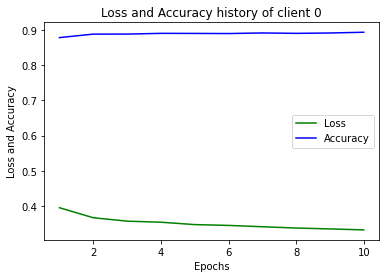

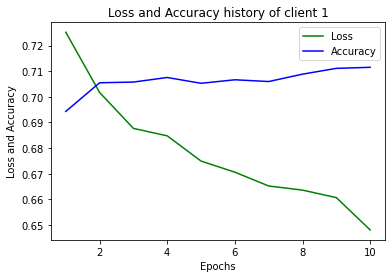

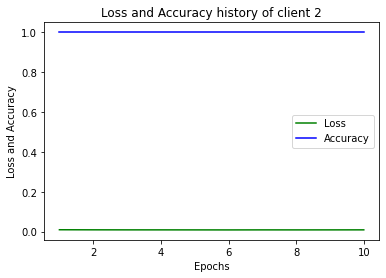

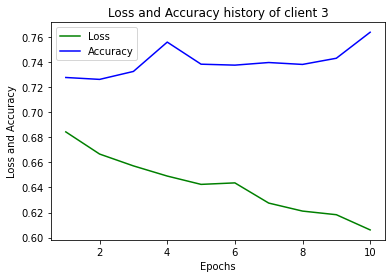

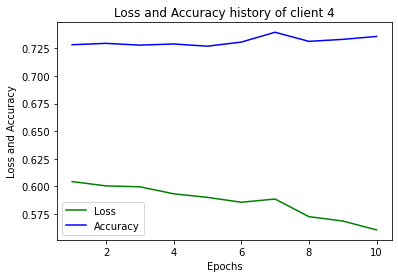

In [14]:
for client in clients:
    client.plot_result(train_rounds)